In [4]:
#!/usr/bin/env python3

from bioblend.galaxy import GalaxyInstance
import pandas as pd
import io
import sys

# === CONFIGURATION ===
GALAXY_URL = "https://usegalaxy.eu"
API_KEY = "cc8ab6117e2e58a8ca8ac12ce8680ed8"                # paste your API key
DATASET_ID = "26c75dcccb616ac8e77d4b636943801c"  # the dataset ID

# --- Connect to Galaxy ---
gi = GalaxyInstance(url=GALAXY_URL, key=API_KEY)

# --- Download dataset content into memory ---
content = gi.datasets.download_dataset(DATASET_ID, use_default_filename=False)

# --- Try to load as CSV, fallback to TSV ---
try:
    df = pd.read_csv(io.BytesIO(content), comment="#")
except Exception:
    df = pd.read_csv(io.BytesIO(content), sep="\t", comment="#")

print(f"✅ Loaded dataset {DATASET_ID} with shape {df.shape}")
print(df.head())


✅ Loaded dataset 26c75dcccb616ac8e77d4b636943801c with shape (927, 6)
                                              genome secondary_cluster  \
0       RNODE_577_length_7056_cov_38.11425_ref.fasta               1_0   
1       RNODE_578_length_7436_cov_10.94682_ref.fasta               2_0   
2         GCF_000001735.4_TAIR10.1_genomic_ref.fasta               3_0   
3  Umbelopsis_autotrophica_MPI-SW4-AT-0611.contig...               4_0   
4  Talaromyces_verruculosus_MPI-SP2-AT-0411.conti...               5_0   

   threshold cluster_method comparison_algorithm  primary_cluster  
0       0.05        average                ANImf                1  
1       0.05        average                ANImf                2  
2       0.05        average                ANImf                3  
3       0.05        average                ANImf                4  
4       0.05        average                ANImf                5  


📊 Cluster type summary:
   total_clusters  clusters_with_ref_and_others  clusters_only_ref  \
0             775                            47                460   

   clusters_no_ref  total_ref_genomes  total_nonref_genomes  
0              268                574                   353  

🔍 Cluster breakdown (first 5):
  secondary_cluster  n_total  n_ref  n_nonref                        all_ref  \
0             100_0        1      0         1                                  
1             101_0        1      0         1                                  
2             102_0        1      1         0  1048983.PRJNA245774_ref.fasta   
3             103_0        1      1         0    525897.PRJNA29527_ref.fasta   
4             104_0        1      1         0  1459636.PRJNA235208_ref.fasta   

                                          all_others cluster_type  
0  anonymous_reads_150__name_anonymous_reads.fq_b...       no_ref  
1  anonymous_reads_22__name_anonymous_reads.fq_bi...       no_

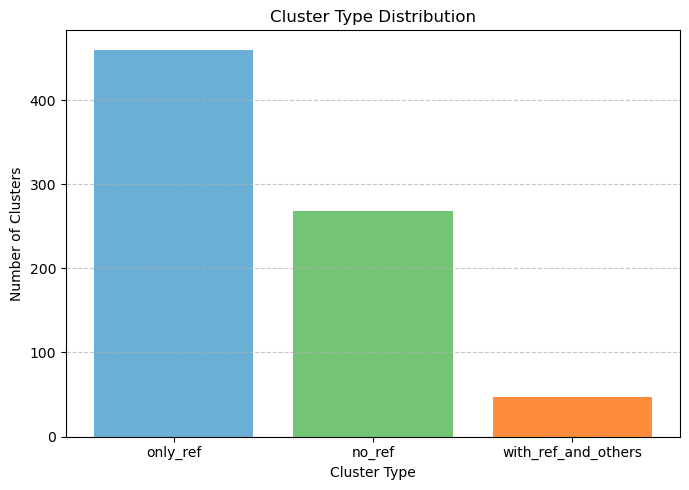

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Identify _ref genomes ---
df["is_ref"] = df["genome"].str.contains("_ref", case=False, na=False)

# --- Aggregate cluster info ---
cluster_stats = (
    df.groupby("secondary_cluster")
    .agg(
        n_total=("genome", "count"),
        n_ref=("is_ref", "sum"),
        n_nonref=("is_ref", lambda x: (~x).sum()),
        all_ref=("genome", lambda g: ", ".join(sorted(g[df.loc[g.index, "is_ref"]]))),
        all_others=("genome", lambda g: ", ".join(sorted(g[~df.loc[g.index, "is_ref"]]))),
    )
    .reset_index()
)

# --- Classify clusters ---
def classify_cluster(row):
    if row["n_ref"] > 0 and row["n_nonref"] > 0:
        return "with_ref_and_others"
    elif row["n_ref"] > 0:
        return "only_ref"
    else:
        return "no_ref"

cluster_stats["cluster_type"] = cluster_stats.apply(classify_cluster, axis=1)

# --- Global summaries ---
all_ref_genomes = sorted(df.loc[df["is_ref"], "genome"].unique())
all_nonref_genomes = sorted(df.loc[~df["is_ref"], "genome"].unique())

global_summary = {
    "total_clusters": len(cluster_stats),
    "clusters_with_ref_and_others": (cluster_stats["cluster_type"] == "with_ref_and_others").sum(),
    "clusters_only_ref": (cluster_stats["cluster_type"] == "only_ref").sum(),
    "clusters_no_ref": (cluster_stats["cluster_type"] == "no_ref").sum(),
    "total_ref_genomes": len(all_ref_genomes),
    "total_nonref_genomes": len(all_nonref_genomes),
}

summary_df = pd.DataFrame([global_summary])
type_counts = (
    cluster_stats["cluster_type"]
    .value_counts()
    .rename_axis("cluster_type")
    .reset_index(name="count")
)

# --- Print results ---
print("📊 Cluster type summary:")
print(summary_df)
print("\n🔍 Cluster breakdown (first 5):")
print(cluster_stats.head())

# --- Bar plot of cluster types ---
plt.figure(figsize=(7, 5))
plt.bar(type_counts["cluster_type"], type_counts["count"], color=["#6baed6", "#74c476", "#fd8d3c"])
plt.title("Cluster Type Distribution")
plt.xlabel("Cluster Type")
plt.ylabel("Number of Clusters")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

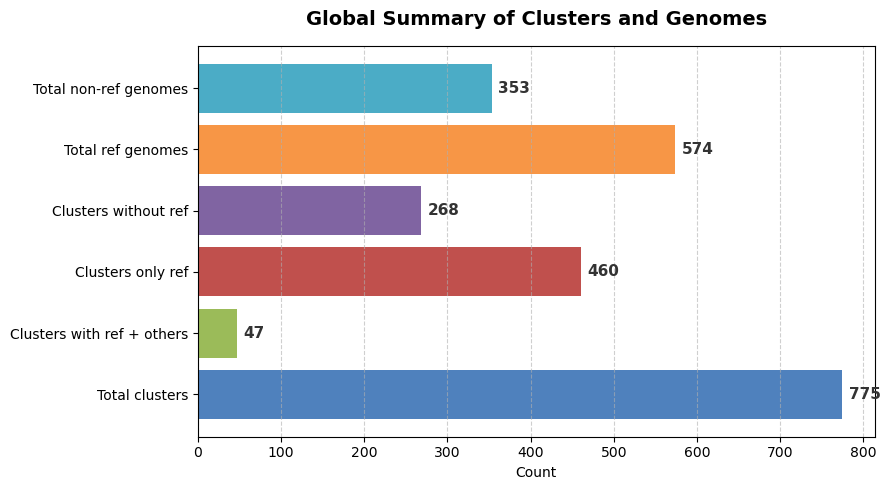

In [15]:
# Extract values (for simplicity)
stats = summary_df.iloc[0].to_dict()

# Define labels and values for plotting
labels = [
    "Total clusters",
    "Clusters with ref + others",
    "Clusters only ref",
    "Clusters without ref",
    "Total ref genomes",
    "Total non-ref genomes",
]
values = [
    stats["total_clusters"],
    stats["clusters_with_ref_and_others"],
    stats["clusters_only_ref"],
    stats["clusters_no_ref"],
    stats["total_ref_genomes"],
    stats["total_nonref_genomes"],
]

# === Plot ===
plt.figure(figsize=(9, 5))
bars = plt.barh(labels, values, color=["#4F81BD", "#9BBB59", "#C0504D", "#8064A2", "#F79646", "#4BACC6"])

# Add annotations on each bar
for bar, val in zip(bars, values):
    plt.text(
        val + max(values) * 0.01,  # position slightly right of bar
        bar.get_y() + bar.get_height() / 2,
        f"{val:,}",  # formatted with comma separator
        va="center",
        ha="left",
        fontsize=11,
        fontweight="bold",
        color="#333333",
    )

plt.title("Global Summary of Clusters and Genomes", fontsize=14, fontweight="bold", pad=15)
plt.xlabel("Count")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()

plt.show()